# Ch05-2 교차 검증과 그리드 서치

모델의 성능을 평가 할 때, 반복적으로 테스트 세트를 사용하여 평가한다면. 결국 테스트 세트에 맞추는 것 아닌가?
따라서, 테스트 세트로 일반화 성능을 올바르게 예측하려면 가능한 테스트 세트를 사용하지 않고, 마지막에 딱 한번만 사용하는 것이 좋다.  

그렇다면, max_depth 매개 변수를 사용한 하이퍼 파라미터 튜닝은 어떻게 할 수 있을까?  

## 1. 검증 세트  Validation set 

100 중에 훈련 세트 60% + 검증 세트 20%  + 테스트 세트 20% 로 나누기!  



In [ ]:
import pandas as pd
wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [ ]:
data = wine[['alcohol', 'sugar', 'pH']]
target = wine['class']  

In [ ]:
#훈련 세트와 테스트 세트 나누기
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

train_input과 tarin_target을 다시 train_Test_split 함수에 넣어 
- 훈련 세트 sub_input, sub_target과 검증세트 val_input, val_target을 만들기 

In [ ]:
sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)


In [ ]:
#훈련 세트와 검증 세트의 크기 확인하기
print(sub_input.shape, val_input.shape)

(4157, 3) (1040, 3)


In [ ]:
#다시 나눈 훈련세트 sub_input, sub_target과 검증 세트 val_input, val_target을 사용하여 모델 훈련 및 평가
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)
print(dt.score(sub_input, sub_target))  #훈련 세트 점수
print(dt.score(val_input, val_target))  #검증 세트 점수 

0.9971133028626413
0.864423076923077


훈련 세트 > 검증 세트  == 과대적합

## 2. 교차 검증

검증 세트를 따로 떼어서 훈련 세트 수가 줄었음.  
훈련 세트가 더 클 수록 좋은 모델이 만들어지지만, 검증 세트를 너무 조금 떼면 검증 점수가 불안정함.   
***교차 검증 cross validation*** 을 이용하면 안정적인 검증 점수를 얻고 훈련에 더 많은 데이터를 사용할 수 있음.

**교차 검증** = 검증 세트를 떼어 내어 평가하는 과정을 여러 번 반복 -> 이 점수의 평균 = 최종 검증 점수  

<3-폴드 교차 검증> 
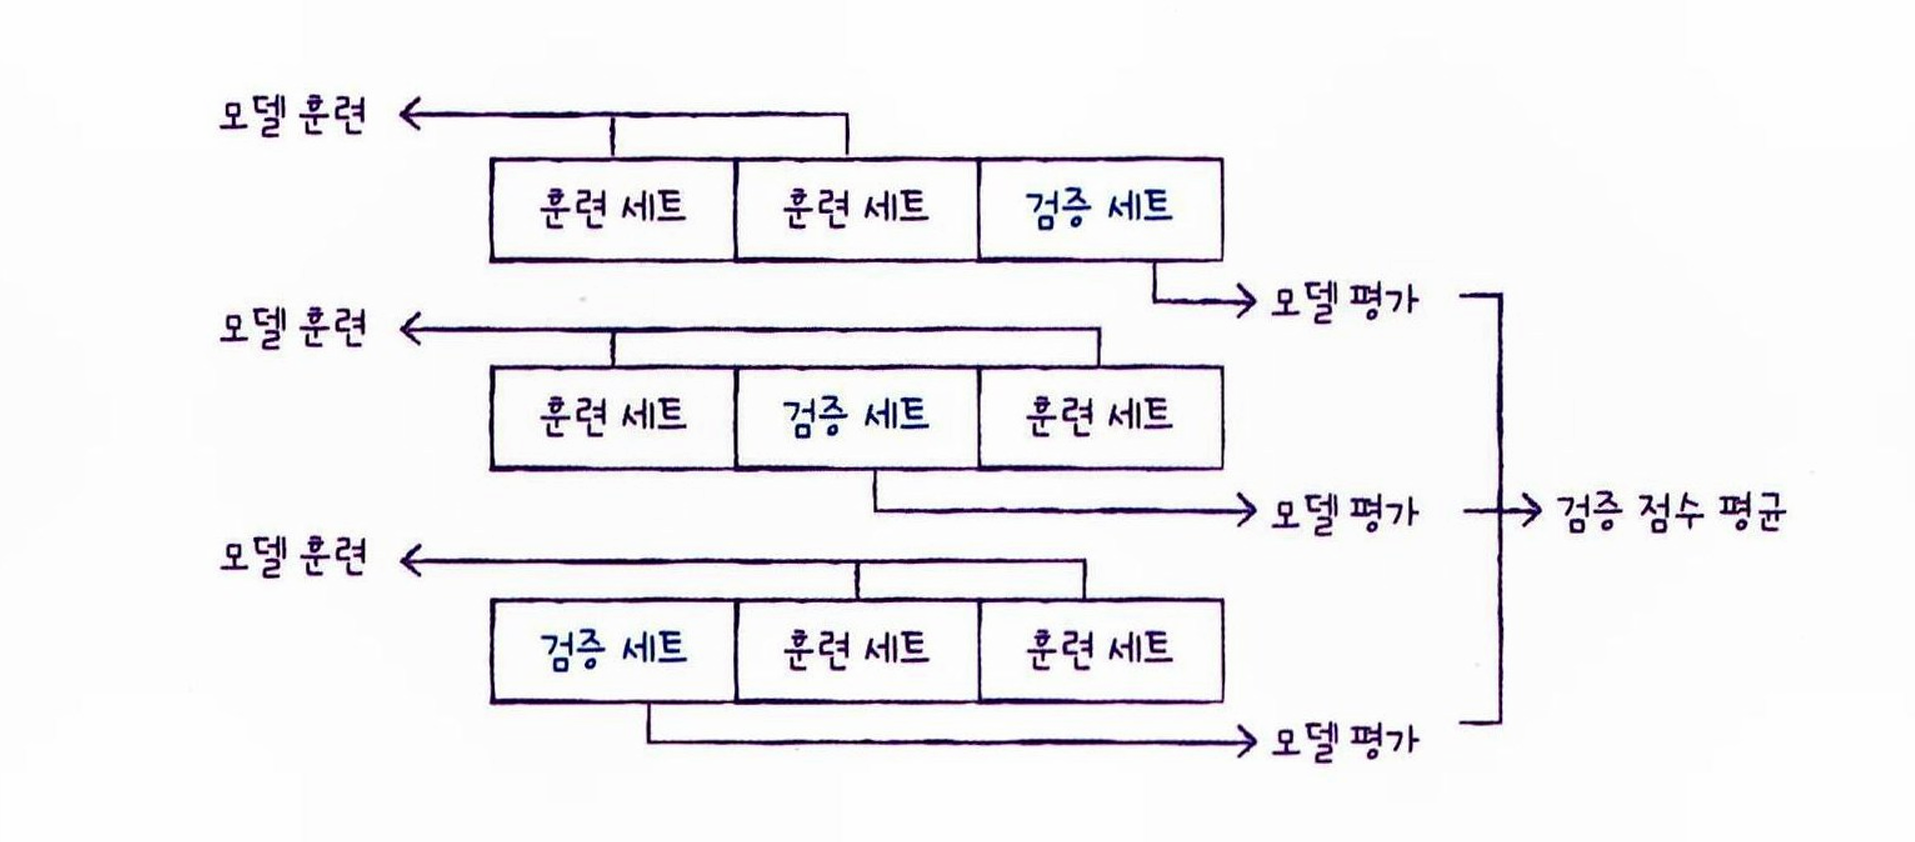

***k-fold cross validation***

보통 5 폴드나 10 폴드르 주로 사용  

**교차 검증 함수 `cross_validate()`**

1. 평가할 모델 객체를 첫 번째 매개 변수로 전달
2. 직접 검증 세트를 떼지 않고, 훈련 세트 전체를 `cross_Validate()`에 전달

In [ ]:
from sklearn.model_selection import cross_validate
scores = cross_validate(dt, train_input, train_target)
print(scores)

{'fit_time': array([0.00927782, 0.00701451, 0.00880098, 0.00568914, 0.00544357]), 'score_time': array([0.00252175, 0.00179386, 0.00261378, 0.0014472 , 0.00148106]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


* fit_time : 모델을 훈련하는 시간
* score_time : 모델을 검증하는 시간
* test_score : 

각각 5개의 숫자 = 5폴드 검증
`cross_validate()` 함수의 default = 5번  

***교차 검증의 최종 점수는 test_score에 담긴 5개의 점수의 평균***


In [ ]:
import numpy as np
print(np.mean(scores['test_score']))

0.855300214703487


그러나, `cross_validate()`는 훈련 세트를 섞지 않기 때문에 교차 검증을 할 때에는 분할기 splitter을 지정해야 함  

`cross_validate()` 함수 
- 회귀 모델일 때 `KFold` 분할기 사용
- 분류 모델일 때 `StratifiedKFold` 사용 

In [ ]:
from sklearn.model_selection import StratifiedKFold
scores = cross_validate(dt, train_input, train_target,
                        cv=StratifiedKFold()) #계층별 폴드 세트 생성
print(np.mean(scores['test_score']))

0.855300214703487


In [ ]:
#훈련 세트를 섞은 후 10폴드 세트로 교차검증을 수행할 때
splitter = StratifiedKFold (n_splits=10, shuffle=True, random_state=42) #n_splits=10 : 10폴드 세트, shuffle=True : 섞기
scores = cross_validate(dt, train_input, train_target,
                        cv=splitter) 
print(np.mean(scores['test_score']))

0.8574181117533719


## 3. 하이퍼 파라미터 튜닝  
- 모델 파라미터 : 머신 러닝 모델이 학습하는 파라미터  
- 하이퍼 파라미터 : 모델이 학습할 수 없어서 사용자가 직접 지정해야하는 파라미터  

### 하이퍼 파라미터 튜닝하는 법
1. 라이브러리가 제공하는 기본값을 사용해 모델 훈련  
2. 검증 세트의 점수나 교차 검증을 통해 매개 변수를 조금씩 바꿈  
    a. 모델마다 적게는 1~2개, 많게는 5~6개의 매개 변수 제공  
    b. 만약 매개변수가 2개라면 2개 다 조절해야 함  

### Grid Search 

`GridSearchCV` 클래스 = 하이퍼파라미터 탐색과 교차 검증을 한 벙네 수행하는 클래스  
 - 별도로 cross_validate() 함수를 호출할 필요 없음  
 

In [ ]:
#gridsearchcv 예제
from sklearn.model_selection import GridSearchCV
params = {'min_impurity_decrease':[0.0001, 0.0002, 0.0003, 0.0004, 0.0005]} #그리드 서치에서 사용할 매개 변수 목록을 딕셔너리로 만듦


In [ ]:
# 탐색 대상 모델과 params 변수를 전달하여 그리드 서치 객체 생성
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1) #n_jobs=-1 : 모든 CPU 코어 사용


In [ ]:
# gs 객체에 훈련 세트로 fit() 메서드 호출
gs.fit(train_input, train_target)

,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'min_impurity_decrease': [0.0001, 0.0002, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


- 그리드 서치 객체는 `min_impurity_decrease` 값을 바꿔가며 결정 트리 모델을 사용해 교차 검증을 총 5번 실행함.  

`GridSearchCV`의 cv 매개 변수 default 값은 5  
따라서, `min_impurity_decrease` 값 마다 5폴드 교차 검증을 수행  
== 5 x 5 = 25 개의 모델을 훈련하는 것  

- n_jobs  = 사용할 cpu 코어 수  
    - n_jobs = -1 로 하면 모든 코어를 사용  


***그리드 서치는 훈련이 끝나면 교차 검증 점수가 가장 높은 모델의 매개 변수 조합으로 전체 훈련세트에서 자동으로 다시 모델을 훈련***  
해당 모델은 gs 객체의 `best_estimator_` 속성에 저장되어있음 
-> 이 모델을 일반 결정 트리처럼 사용하면 됨  


In [ ]:
dt = gs.best_estimator_  #최적의 모델을 dt에 저장
print(dt.score(train_input, train_target))  #훈련 세트 점수

0.9615162593804117


그리드 서치로 찾은 최적의 매개변수는 `best_parmas_` 속성에 저장되어있음  

In [ ]:
print(gs.best_params_)  #최적의 매개 변수   

{'min_impurity_decrease': 0.0001}


각 매개변수에서 수행한 교차 검증의 평균 점수는 `cv_results_` 속성의 'mean_test_score'키에 저장되어 있음

In [ ]:
print(gs.cv_results_['mean_test_score'])  #각 매개변수에서 수행한 교차 검증의 평균 점수

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


gs 객체의 best_index_ 속성을 사용하면 가장 높은 값의 인덱스를 얻을 수 있고,  
parmas 키에 저장된 매개 변수를 출력할 수 있음  

= ***최상의 검증 점수를 만든 매개변수 조합*** 

In [ ]:
print(gs.cv_results_['params'][gs.best_index_]) #최상의 검증 점수를 만든 매개변수 조합 = gs.best_params_와 동일

{'min_impurity_decrease': 0.0001}


### 총 정리
1. 먼저 탐색할 매개변수를 지정
2. 훈련 세트에서 그리드 서치 수행하여 최상의 평균 검증 점수가 나오는 매개 변수 조합을 찾음
    a. 이 조합은 그리드 서치 객체에 저장됨
3. 그리드 서치는 최상의 매개 변수에서 전체 훈련 세트를 사용해 최종 모델을 훈련함 
    a. 이 모델도 그리드 서치 객체에 저장됨
    

**복잡한 매개변수 조합 예시**
노드를 분할하기 위한 불순도 감소 최소량을 지정하는 
`min_impurity_decrease`와  
`max_depth`로 트리의 깊이를 제한하고,  
`min_samples_split` 으로 노드를 나누기 위한 최소 샘플 수를 골라보기  

In [37]:
params = {'min_impurity_decrease':np.arange(0.0001, 0.001, 0.0001), # 1
            'max_depth':range(5, 20, 1), 'min_samples_split':range(2, 100, 10)} # 2


**1 numpy arange() 함수**  
- 첫 번째 매개 변수 값에서 두 번째 매개 변수에 도달할 때까지 세 번째 매개변수를 계속 더한 배열을 만듦 
    - 0.0001 에서 시작해서 0.001이 될 때까지 0.0001을 계속 더한 배열 (1에서 10까지 총 9번 ) 원소 총 **9개**   

**2 python range() 함수**  
- 비슷하지만 정수만 사용 가능.  
    - `max_dept`를 5에서 20까지 1씩 증가 = **15개** (5, 6, ... 19)
    - `min_samples_split` 은 2에서 100까지 10씩 증가 = **10개**  (2, 12, 22, ... , 92)

**최종 교차 검증 횟수** 
9 * 15 * 10 = 1350 개  
-> 기본 5폴드 교차 검증  = 1350 * 5 = 6750개  

In [38]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'max_depth': range(5, 20), 'min_impurity_decrease': array([0.0001... 0.0009]), 'min_samples_split': range(2, 100, 10)}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [39]:
#최상의 매개변수 조합 확인 
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': np.float64(0.0004), 'min_samples_split': 12}


In [40]:
# 최상의 교차 검증 점수 확인
print(gs.best_score_)

0.8683865773302731


***결론***
GridSearchCV 클래스를 사용하면, 매개 변수를 일일이 바궈가며 교차 검증을 수행하지 않고, 원하는 매개변수 값을 나열하면 자동으로 교차 검증을 수행해서 최상의 매개변수를 찾을 수 있다.  

? 혹시 탐색할 매개 변수의 간격을 0.0001 이나 1이 아니라 다른 간격으로 할 수 있지 않을까??



## 3. 랜덤 서치  Random search

매개 변수 값의 목록을 전달하는 것이 아니라 매개변수를 샘플링할 수 있는 확률 분포 객체를 전달  
`scipy` 라이브러리
 - 과학 라이브러리 
    - 적분, 보간, 선형 대수, 확률 등 수치 계산 전용 라이브러리  


In [41]:
from scipy.stats import uniform, randint #확률 분포 객체를 제공하는 scipy 라이브러리

In [42]:
rgen = randint(0, 10)  #0부터 10미만의 균등한 정수형 난수 생성기
rgen.rvs(10)   #10개의 난수 샘플 생성

array([4, 4, 1, 3, 5, 9, 1, 3, 6, 9])

In [43]:
np.unique(rgen.rvs(1000), return_counts=True) #1000개의 샘플에서 생성된 고유한 값과 각 값의 빈도수 확인

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 89, 113, 113,  99,  95, 102, 108,  93,  78, 110]))

1000개를 하니까 골고루 나오는 것을 알 수 있음.

In [44]:
ugen = uniform(0, 1)  #0부터 1사이의 균등한 실수형 난수 생성기 uniform = 실수 
ugen.rvs(10)  #10개의 난수 샘플 생성

array([0.96390565, 0.51129366, 0.25719149, 0.79117445, 0.36797546,
       0.10830147, 0.52422384, 0.67218614, 0.83634355, 0.53702817])

이제, 랜덤 서치에 randint와 uniform 클래스 객체를 넘겨주고 여러번 샘플링해서 최적의 매개 변수를 찾으라고 명령할 수 있음  
샘플링 횟수는 시스템 자원이 허락하는 한 최대한 크게  

매개변수의 딕셔너리를 만들어서 매개변수를 탐색 대상에 추가  

In [48]:
params = {'min_impurity_decrease': uniform(0.0001, 0.001),  #0.0001부터 0.001 사이의 균등 분포에서 샘플링
            'max_depth': randint(20, 50),  #20부터 50미만의 균등 분포에서 샘플링
            'min_samples_split': randint(2, 25), #2부터 25미만의 균등 분포에서 샘플링
'min_samples_leaf': randint(1, 25)}  #1부터 25미만의 균등 분포에서 샘플링

* min_impurity_decrease = 0.0001 ~ 0.001 사이 실숫값 샘플링
* max_depth = 20 ~ 50 사이의 정수
* min_samples_split = 2~25 사이의 정수
* min_samples_leaf = 1~25 사이의 정수  
이를 랜덤 서치 클래스인 `RandomizedSearchCV`의 n_iter 매개변수에 지정  

In [49]:
from sklearn.model_selection import RandomizedSearchCV
rs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, n_iter=100, n_jobs=-1, random_state=42) 

rs.fit(train_input, train_target)

,estimator,DecisionTreeC...ndom_state=42)
,param_distributions,"{'max_depth': <scipy.stats....x7547a26fb700>, 'min_impurity_decrease': <scipy.stats....x7547a26fa410>, 'min_samples_leaf': <scipy.stats....x7547a26fa320>, 'min_samples_split': <scipy.stats....x7547a26faf80>}"
,n_iter,100
,scoring,None
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [50]:
#매개변수 최적의 조합 출력
print(rs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': np.float64(0.00034102546602601173), 'min_samples_leaf': 7, 'min_samples_split': 13}


In [51]:
#교차검증 점수 확인
print(rs.best_score_)

0.8695428296438884


In [52]:
#최종 모델로 결정하고 테스트 세트 성능 확인
dt = rs.best_estimator_
print(dt.score(test_input, test_target))

0.86


테스트 세트 점수는 검증 세트에 대한 점수보다 조금 작은 것이 일반적임.  
